In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 18
plt.rcParams['text.usetex'] = False

$$
\newcommand{\ket}[1]{|#1\rangle}
\newcommand{\fe}{\delta f}
\newcommand{\fee}{\hat{\fe}}
$$
## 2 point Ramsey with Bayesian inference

We are looking for the optimal solution to the problem of estimating the frequency of a qubit using a Ramsey type scan below a certain error threshold, at minimal time. The considerations are:

1. We have computational resources close to the calculation. But they are limited in the sense that they are fixed point and we want them to be lightweight

2. ...

Let's look at solving this problem using Bayesian inference. The idea is that at a given measurement delay $\tau \simeq T_2^*$, the probability of getting $\ket{1}$ as a function of the frequency error $\tau\fe$ looks like this:

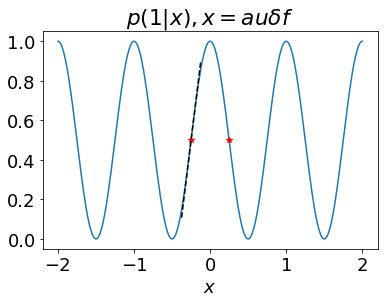

In [3]:
f = np.linspace(-2, 2, 400)
f_near = np.linspace(-1/8, 1/8)
plt.plot(f, (1 + np.cos(2*np.pi*f))/2)
plt.plot([1/4, -1/4], [1/2, 1/2], '*r')
plt.plot(f_near - 1/4, np.pi*f_near+1/2, 'k--')
plt.xlabel('$ x $')
plt.title('$p(1|x), x= \tau \delta f$')
plt.savefig('prob_1_x.svg')

The distribution of measurement outcomes given a frequency error $\fe$ is:

$$p(m=1|\fe) = \frac{1}{2}(1 + \cos(2\pi \tau \fe)).$$

Let's denote 

$$x=\tau \fe.$$

We assume the prior for $x$ is Gaussian with a sigma of $\sigma$:

$$
p(x) \propto \exp(-x^2/2\sigma^2)
$$

We are also working near the optimal points 1/4 and -1/4. We take the difference of a 2 point scan. 

We assume $\sigma \ll 1$ so we can linearize.

The first point has a distribution:
$$
p_1(1|x) \simeq \frac{1}{2} + \pi x
$$
and the second point has a distribution:
$$
p_2(1|x) \simeq \frac{1}{2} - \pi x
$$

thus the difference $d=m_2 - m_1$ has the distribution:
$$
p(d=0|x) = p_1(0|x)p_2(0|x)+p_1(1|x)p_1(1|x) \simeq \frac{1}{2} \\
p(d=1|x) = p_1(0|x)p_2(1|x) \simeq \frac{1}{4} + 2\pi x \\
p(d=-1|x) = p_1(1|x)p_2(0|x) \simeq \frac{1}{4} - 2\pi x
$$

From this we get an experimental approximation of $p(d|x)$, where $d=-1, 0, 1$:

Then we can calculate the update:

$$
p(x|d) = p(d|x)p(x)/p(d).
$$

Thus the new estimate is:
$$
\hat{x}(d) = \arg\max_x(p(x|d)) = \\
 \arg\max_x(p(d|x)p(x))
$$
this has 3 solutions for every value of $d$:
$$
\hat{x}(d=0)=0 \\
\hat{x}(d=1) = \frac{\sqrt{256 \pi^2 \sigma^2 + 1} - 1}{16 \pi} \\
\hat{x}(d=-1) = -\hat{x}(d=1)
$$
Now we move in every step by this estimate, and in the next step we assume again that our distribution has no skew.

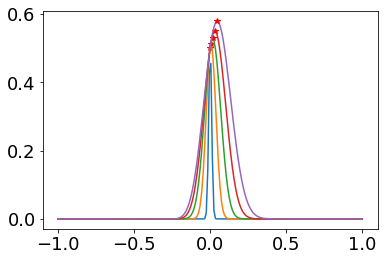

In [68]:
def prob_f_1(x, sigma):
    return 0.5*(1+np.sin(2*np.pi*x))*np.exp(-x**2/(2*sigma**2))

opt = lambda sigma: (np.sqrt(16*np.pi**2*sigma**2 + 1) - 1)/(4*np.pi)


x = np.linspace(-1, 1, 200)
for sigma in np.linspace(0.01, 0.1, 5):
    
    plt.plot(x, prob_f_1(x, sigma))
    plt.plot(opt(sigma), prob_f_1(opt(sigma), sigma), 'r*')

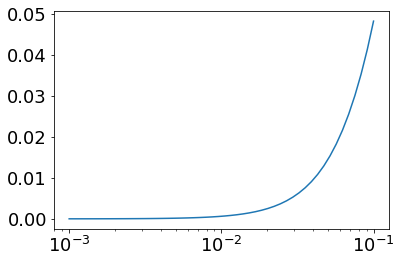

In [70]:
svec = np.logspace(-3, -1)
plt.semilogx(svec, opt(svec))

## Simulating

using a single point estimate

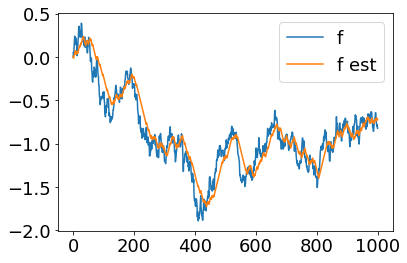

In [98]:
num_steps = 1000
sigma = 0.05
f = 0
f_hist = [0]
f_est = 0
f_est_hist = [0]
for step in range(num_steps):
    f = f + np.random.randn(1)*sigma
    f_hist.append(f)
    p_1_given_f = 0.5*(1 + np.sin(2*np.pi*(f-f_est)))
    meas = 2*int(np.random.rand(1) < p_1_given_f) - 1
    f_est = f_est + opt(sigma) * meas
    f_est_hist.append(f_est)
    

plt.plot(f_hist, label='f')
plt.plot(f_est_hist, label='f est')
plt.legend()
plt.show()
    
    
    

using a 2 point estimate

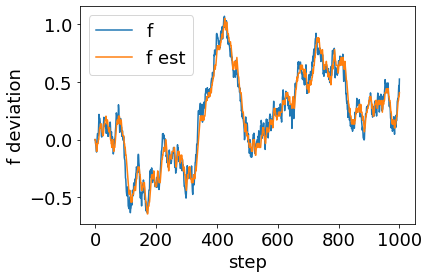

In [10]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 18

opt_2 = lambda sigma : (np.sqrt(256*np.pi**2*sigma**2 + 1) - 1)/(16*np.pi)

num_steps = 1000
sigma = 0.05
f = 0
f_hist = [0]
f_est = 0
f_est_hist = [0]
for step in range(num_steps):
    f = f + np.random.randn(1)*sigma
    f_hist.append(f)
    p_left = 0.5*(1 + np.sin(2*np.pi*(f-f_est)))
    p_right = 0.5*(1 - np.sin(2*np.pi*(f-f_est)))
    m1 = int(np.random.rand(1) < p_left)
    m2 = int(np.random.rand(1) < p_right)
    diff = m2 - m1
    f_est = f_est - opt_2(sigma) * diff
    f_est_hist.append(f_est)
    

plt.plot(f_hist, label='f')
plt.plot(f_est_hist, label='f est')
plt.xlabel('step')
plt.ylabel('f deviation')
plt.legend()
plt.show()
    
    
    